In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

In [ ]:
%cd /content/drive/MyDrive/Colab Notebooks/CV
%ls
!pip install pyunpack
!pip install patool

/content/drive/MyDrive/Colab Notebooks/CV
checkpoints/  dataset/  dataset.rar


     |████████████████████████████████| 81kB 4.4MB/s 


In [ ]:
# write a efficientNet model to classify adoption rate
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras 
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.applications import EfficientNetB0
import glob
import cv2
from tensorflow.keras.preprocessing import image_dataset_from_directory
import tensorflow as tf
import os
import seaborn as sns
from pyunpack import Archive
import os
os.environ["TF_CPP_MIN_CVLOG_LEVEL"] = "2"
%cd /content/drive/MyDrive/Colab Notebooks/CV

/content/drive/MyDrive/Colab Notebooks/CV


In [ ]:
%cp -r dataset.rar ~

In [ ]:
%cd ~
%ls

/root
dataset.rar


In [ ]:
!sudo add-apt-repository multiverse
!sudo apt update
!sudo apt-get install unrar
!unrar x dataset.rar

Streaming output truncated to the last 5000 lines.
Extracting  dataset/train/4/7eae805cd-4.jpg                               90%  OK 
Extracting  dataset/train/4/7eae805cd-5.jpg                               90%  OK 
Extracting  dataset/train/4/7eae805cd-6.jpg                               90%  OK 
Extracting  dataset/train/4/7ec261d88-1.jpg                               90%  OK 
Extracting  dataset/train/4/7ec261d88-2.jpg                               90%  OK 
Extracting  dataset/train/4/7ec261d88-3.jpg                               90%  OK 
Extracting  dataset/train/4/7ecd54695-1.jpg                               90%  OK 
Extracting  dataset/train/4/7ecd54695-2.jpg                               90%  OK 
Extracting  dataset/train/4/7ecd54695-3.jpg                               90%  OK 
Extracting  dataset/train/4/7ecd54695-4.jpg                               90%  OK 
Extracting  dataset/train/4/7

In [ ]:
INPUT_SHAPE = (224,224,3)
IMAGE_SIZE = (224, 224)
NUM_CLASS = 5 # [0,1,2,3,4]
DEST_TRAIN_IMAGE_PATH = "dataset/train"
DEST_TEST_IMAGE_PATH = "dataset/test"

In [ ]:
%cd /content/drive/MyDrive/Colab Notebooks/CV
%pwd

/content/drive/MyDrive/Colab Notebooks/CV


'/content/drive/MyDrive/Colab Notebooks/CV'

In [ ]:
img_augmentation = Sequential(
    [
        preprocessing.RandomRotation(factor=0.15),
        preprocessing.RandomTranslation(height_factor=0.1, width_factor=0.1),
        preprocessing.RandomFlip(),
        preprocessing.RandomContrast(factor=0.1),
    ],
    name="img_augmentation",
)

class AutoSaveCheckpoint(keras.callbacks.Callback):
  def __int__(self):
    super(AutoSaveCheckpoint, self).__init__()
  
  def on_epoch_end(self, epoch, logs=None):
    self.model.save(f"/content/drive/MyDrive/Colab Notebooks/CV/checkpoints/efficientNet-dropout-0.3-{epoch+1}")


def scheduler(epoch, lr):
  if epoch < 15:
    return 0.001
  elif epoch < 25:
    return 0.0005
  else:
    return 0.0001

update_lr_cb = keras.callbacks.LearningRateScheduler(scheduler)
callback_list = [update_lr_cb, AutoSaveCheckpoint()]

def efficientNet_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # x = img_augmentation(inputs)
    eff_model = EfficientNetB0(include_top=False, weights="imagenet", drop_connect_rate=0.3)(inputs)
    x = layers.BatchNormalization()(eff_model)
    x = layers.GlobalAveragePooling2D(name="avg_pool_final")(x)
    x = layers.Dense(512, activation="relu")(x)
    x = layers.Dense(128, activation="relu", name="feature_extractor")(x)
    outputs = layers.Dense(num_classes, activation="softmax", name="pred")(x)

    model = keras.Model(inputs, outputs, name="EfficientNetB0")
    # optimizer = keras.optimizers.Adam(learning_rate=0.01)
    model.compile(
        optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]
    )
    model.summary()
    return model

In [ ]:
%cd /content/drive/MyDrive/Colab Notebooks/CV
%ls

/content/drive/MyDrive/Colab Notebooks/CV
checkpoints/  dataset/  dataset.rar


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0, 0.5, 'Number of images')

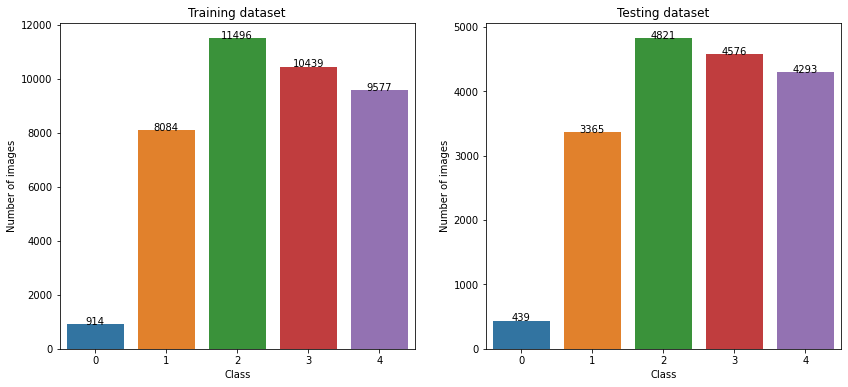

In [ ]:
classes_train = [0,1,2,3,4]
class_train_images = []
for class_name in classes_train:
    image_total = len(os.listdir(os.path.join(DEST_TRAIN_IMAGE_PATH, str(class_name))))
    class_train_images.append(image_total)

classes_test = [0,1,2,3,4]
class_test_images = []
for class_name in classes_test:
    image_total = len(os.listdir(os.path.join(DEST_TEST_IMAGE_PATH, str(class_name))))
    class_test_images.append(image_total)
    
figure, ax = plt.subplots(1,2, figsize=(14,6))
train_sns = sns.barplot(classes_train, class_train_images, ax=ax[0])
for i, class_name in enumerate(classes_train):
    train_sns.text(i, class_train_images[i], class_train_images[i], color='black', ha="center")
ax[0].set_title("Training dataset")
ax[0].set_xlabel("Class")
ax[0].set_ylabel("Number of images")
test_sns = sns.barplot(classes_test, class_test_images, ax=ax[1])
for i, class_name in enumerate(classes_test):
    test_sns.text(i, class_test_images[i], class_test_images[i], color='black', ha="center")
ax[1].set_title("Testing dataset")
ax[1].set_xlabel("Class")
ax[1].set_ylabel("Number of images")

In [ ]:
train_ds = image_dataset_from_directory(
    directory="/root/dataset/train",
    labels='inferred',
    label_mode='categorical',
    batch_size=64,
    image_size=IMAGE_SIZE)

val_ds = image_dataset_from_directory(
    directory='/root/dataset/test',
    labels='inferred',
    label_mode='categorical',
    batch_size=64,
    image_size=IMAGE_SIZE)

train_ds = train_ds.prefetch(buffer_size=128)
val_ds = val_ds.prefetch(buffer_size=128)

Found 40510 files belonging to 5 classes.
Found 17494 files belonging to 5 classes.


In [ ]:
efficientNetB0_model = efficientNet_model(INPUT_SHAPE, NUM_CLASS)
history = efficientNetB0_model.fit(train_ds, epochs=60, validation_data=val_ds, verbose=1, callbacks=callback_list)
efficientNetB0_model.save('checkpoints/checkpoint--dropout-0.3-final.h5')

16711680/16705208 [==============================] - 0s 0us/step
Model: "EfficientNetB0"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
batch_normalization (BatchNo (None, 7, 7, 1280)        5120      
_________________________________________________________________
avg_pool_final (GlobalAverag (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               655872    
_________________________________________________________________
feature_extractor (Dense)    (None, 128)               65664     
_____________________________________________________

In [ ]:
# fine-tunring with higher drop-out rate: 0.35
efficientNetB0_model_higher_dropout = efficientNet_model(INPUT_SHAPE, NUM_CLASS)
efficientNetB0_model_higher_dropout.load_weights("checkpoints/checkpoint-final.h5")
history = efficientNetB0_model_higher_dropout.fit(train_ds, epochs=10, validation_data=val_ds, verbose=1, callbacks=callback_list)
efficientNetB0_model_higher_dropout.save('checkpoints/checkpoint-0.35-dropout-rate.h5')

Model: "EfficientNetB0"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
img_augmentation (Sequential (None, 224, 224, 3)       0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 7, 1280)        5120      
_________________________________________________________________
avg_pool_final (GlobalAverag (None, 1280)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               655872    
_________________________________________________________________
feature_extractor (Dense)    (None, 128)            

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# # reload and retrain previous model
# model = keras.models.load_model('checkpoints/checkpoint-20.h5')
# optimizer = keras.optimizers.Adam(learning_rate=0.0001)
# model.compile(
#       optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
#     )
# model.fit(train_ds, epochs=5, validation_data=val_ds, verbose=1)
# model.save('checkpoints/checkpoint-25.h5')

In [ ]:
feature_extractor = keras.Model(
    inputs=efficientNetB0_model.inputs,
    outputs=efficientNetB0_model.get_layer(name="feature_extractor").output
)


In [ ]:
image = cv2.imread("dataset/test/0/0e4cf50f4-1.jpg")
image = cv2.resize(image, IMAGE_SIZE)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = np.reshape(image, (1, 224, 224, 3))
features = feature_extractor(image)
print(features)